<a href="https://colab.research.google.com/github/Fuenfgeld/Agent_Tutorial_PydanticAI/blob/main/01_IntroductionPydanticAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup Notebook

In [ ]:
%pip -q install pydantic-ai
%pip -q install nest_asyncio
%pip -q install logfire

In [ ]:
import os
from google.colab import userdata

keyAntropic = userdata.get('Claude')
keyOpenAI = userdata.get('openAI')
keyLogFire = userdata.get('logfire')


os.environ["OPENAI_API_KEY"] = keyOpenAI
os.environ["ANTHROPIC_API_KEY"] = keyAntropic

import nest_asyncio
nest_asyncio.apply()

## Agent Setup


PydanticAI is model agnostic and can utilize most LLM models. PydanticAI can use most models either offered via API (openAI, Antropic, Mistral ...) or self-hosted models (llama, deepseek R1 ...). Switching out models is easy and seamless.



### openAI model

In [ ]:
from pydantic_ai import Agent
from pydantic_ai.messages import ModelMessage
from pydantic_ai.models.openai import OpenAIModel

openAI_model = OpenAIModel('gpt-4o-mini')
agent = Agent(model=openAI_model)

result = agent.run_sync(user_prompt="What are the official languages in Luxembourg")
print(result.output)


### Antropic model

In [ ]:
from pydantic_ai.models.anthropic import AnthropicModel

claude_model = AnthropicModel('claude-3-5-haiku-latest')
agent = Agent(model=claude_model)

result = agent.run_sync(user_prompt="What are the official languages in Luxembourg")
print(result.output)

## logfire

logfire is a platform that helps you debug Agent systems. It is tightly integrated with pydanticAI and helps you with logging, tracing, and debugging.

In [ ]:
import logfire

# Configure logfire
logfire.configure(token=keyLogFire)

# Send a log
logfire.info('System check, thanks good its {date}', date='Friday')

### Spans
Logfire spans are the building blocks of traces in the Logfire observability platform. A span represents a single unit of work or operation within your application, allowing you to measure the execution time of code and add contextual information to your logs. Each span can be thought of as a log entry with extra capabilities-specifically, timing and context

In [ ]:
with logfire.span('Calling Agent') as span:
    result = agent.run_sync("What are the official languages in Luxembourg")
    span.set_attribute('result', result.output)
    logfire.info('{result=}', result=result.output)

### logging Levels

The next example uses the Logfire API to log the same result at several different severity levels. Each line is a logging statement, but the log level determines how important or critical the message is in the context of your application. Logfire supports multiple log levels, including notice, info, debug, warn, error, and fatal.
Here’s what each level means and when you might use it:
* notice: For significant, but not urgent, events that should be highlighted for operators or administrators.
* info: For routine information about the application's operation, typically confirming that things are working as expected.
* debug: For detailed diagnostic messages, usually only enabled during development or troubleshooting.
* warn: For potentially harmful situations that are not immediately critical but may cause problems.
* error: For serious problems that prevent some operation from completing.
* fatal: For very severe errors that will likely cause the application to terminate.





In [ ]:
with logfire.span('Calling Agent') as span:
    result = agent.run_sync("What are the official languages in Luxembourg")
    logfire.notice('{result=}', result=result.output)
    logfire.info('{result=}', result=result.output)
    logfire.debug('{result=}', result=result.output)
    logfire.warn('{result=}', result=result.output)
    logfire.error('{result=}', result=result.output)
    logfire.fatal('{result=}', result=result.output)

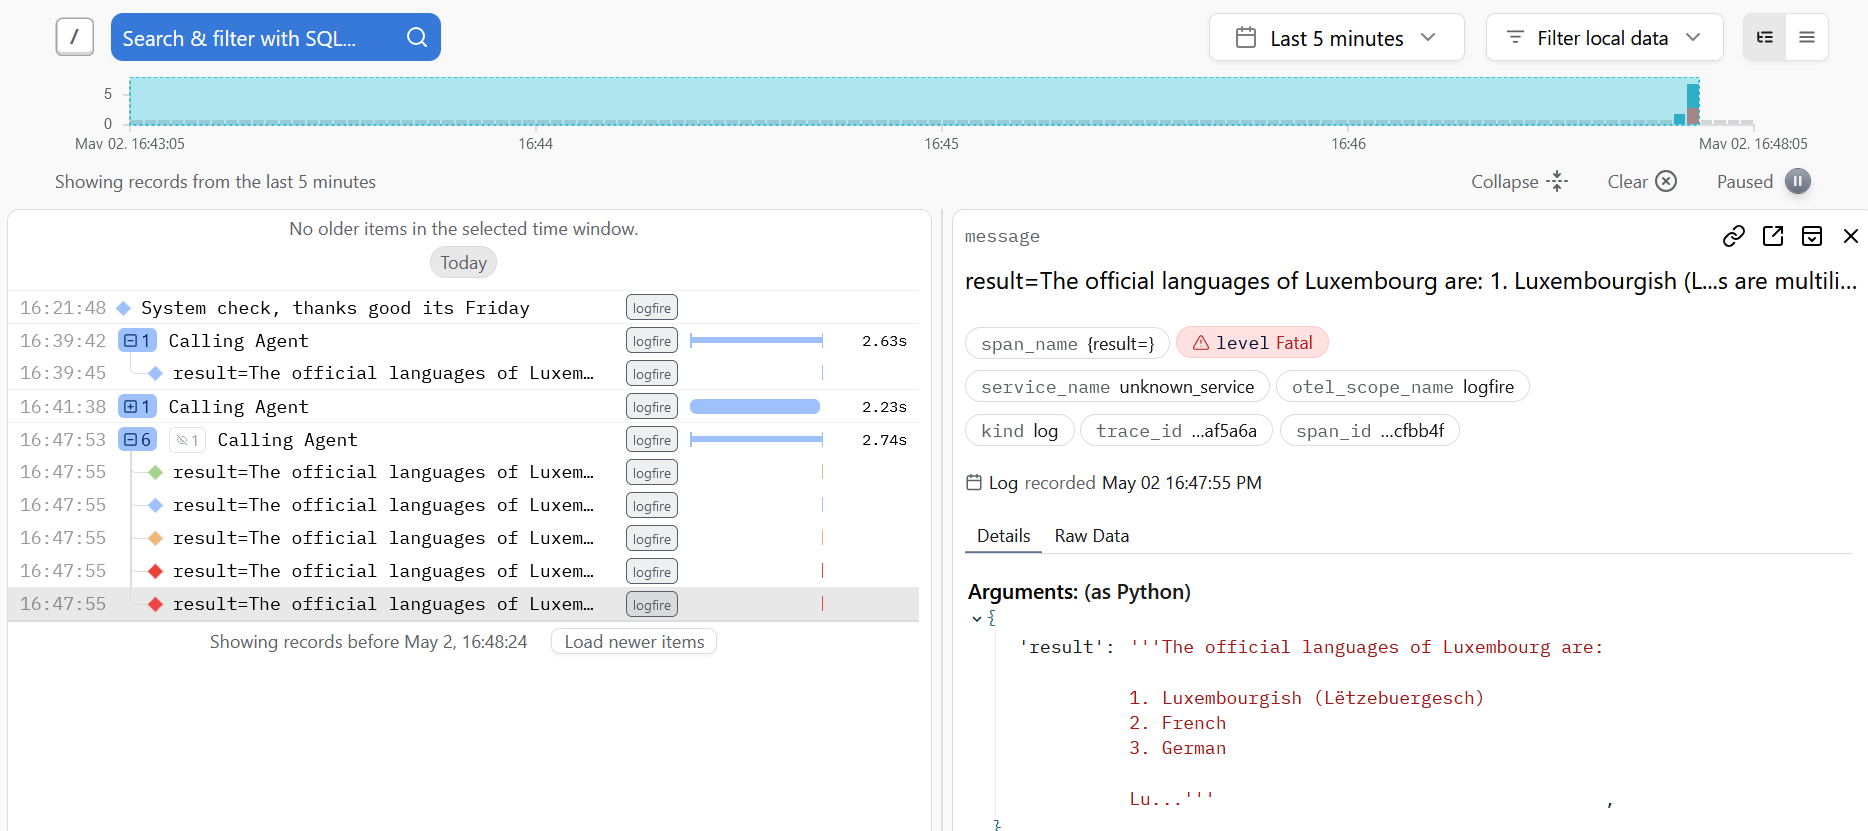